In [28]:
#!pip install pillow


In [304]:
from PIL import Image, ImageOps
import shutil
import os
import pandas as pd
import numpy as np
from collections import Counter

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense


In [317]:
def max_sizes(input_folder,limit_width=None):
    max_width = 0
    max_height = 0
    # First, iterate through all images to find the maximum dimensions
    for filename in os.listdir(input_folder):
        if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
            file_path = os.path.join(input_folder, filename)
            with Image.open(file_path) as img:
                width, height = img.size
                if width > max_width:
                    max_width = width
                if height > max_height:
                    max_height = height
    if limit_width != None:
        max_height = int(round(max_height*limit_width/max_width,0))
        max_width = limit_width
    return max_width, max_height


# Define the range of white color
def is_white_color(color, threshold=230):
    # Check if color is close to white within the given threshold
    return all(c >= threshold for c in color)


# Adjust threshold based on what is considered "close to white"
def crop_white_bottom_from_image(img, check_hight=8, check_width=10, start_from=60, threshold=230):
    width, height = img.size
    # Define the region to check for white color
    box = (start_from, height - check_hight, start_from + check_width, height)
    region = img.crop(box)
    # Convert the region to a NumPy array for easy processing
    region_np = np.array(region)
    # Check if all pixels in the region are close to white
    white_pixels = np.apply_along_axis(is_white_color, 1, region_np)
    
    if np.all(white_pixels):
        # Crop the bottom 16 pixels
        img = img.crop((0, 0, width, height - check_hight - 8))
    return img


def padding_images(img,max_width,max_height):
    # Calculate padding required to center the image
    delta_width = max_width - img.width
    delta_height = max_height - img.height
    padding = (delta_width // 2, delta_height // 2, delta_width - (delta_width // 2), delta_height - (delta_height // 2))
    # Add padding and create a new image with the desired size
    return ImageOps.expand(img, padding, fill=0)

def format_to_rgb(img):
    if img.mode != 'RGB':
        # Convert image to RGB
        img = img.convert('RGB')
    return img

def reducing_width(img, max_width=640):
    #Get the image dimensions
    width, height = img.size
    # If the image width is greater than 640, resize it
    if width > max_width:
        # Calculate the scaling factor
        scale_factor = max_width / width
        new_width = max_width
        new_height = int(height * scale_factor)
        # Resize the image
        img = img.resize((new_width, new_height), Image.LANCZOS)
    return img

def is_bright_orange(rgb):
    r, g, b = rgb
    # Approximate boundaries for bright orange color in RGB
    return (r > 180 and 50 < g < 200 and b < 110)

def replace_logo_with_neighboring_colors(img,search_area_height=50, search_area_width=50):
    #Get the image dimensions
    width, height = img.size
    pixels = img.load()

    # List to store coordinates of orange pixels
    orange_points = []

    # Iterate over the bottom-left 50x50 rectangle
    for x in range(search_area_width):
        for y in range(height - search_area_height, height):
            if is_bright_orange(pixels[x, y]):
                orange_points.append((x, y))
 
    # If orange pixels are found
    if orange_points:
        # Find the top-right orange point and take some points more
        max_orange_x = max(x for x,y in orange_points)+3
        min_orange_y = min(y for x,y in orange_points)-5

        # Replace logo with vertical lines. Color is like color of pixel above
        for x in range(max_orange_x):
            color = pixels[x, min_orange_y-1]
            for y in range(min_orange_y, height):
                pixels[x, y] = color
    return img



In [314]:
# Augmentation for birds and hogs

def augment_class_images(input_folder, label_csv, target_classes):
    # Load the CSV file with labels
    df = pd.read_csv(label_csv)
    # Calculate the average number of images across all classes
    class_counts = df.drop(columns=['id']+target_classes).sum(axis=0)
    avg_count = int(class_counts.mean())

    # Create a generator for data augmentation
    datagen = ImageDataGenerator(
        rotation_range=10,       # Rotations
        width_shift_range=0.1,   # Width shifts
        height_shift_range=0.1,  # Height shifts
        shear_range=0.1,         # Shear angle shifts
        zoom_range=0.1,          # Zooming
        horizontal_flip=True,    # Horizontal flipping
        fill_mode='nearest'      # Filling new pixels after transformation
    )
    # Perform augmentation for each target class
    for target_class in target_classes:
        # Filter the dataframe for the target class
        class_df = df[df[target_class] == 1]
        # Calculate how many images need to be generated
        num_images_needed = avg_count - len(class_df)

        # Create output folder for the augmented images
        output_folder = os.path.join(input_folder, target_class)#f'{target_class}_augmented')

        # Check if the directory exists
        if os.path.exists(output_folder):
            #Delete the directory along with its contents
            shutil.rmtree(output_folder)

        os.makedirs(output_folder, exist_ok=True)
        for _ in range(num_images_needed): 
            random_id = class_df['id'].sample(n=1).iloc[0] 
            img_path = os.path.join(input_folder, random_id+'.jpg')
            img = load_img(img_path)
            x = img_to_array(img)  # Convert image to numpy array
            x = x.reshape((1,) + x.shape)  # Add dimension to work with ImageDataGenerator
            # Generate new images
            for batch in datagen.flow(x, batch_size=1,save_to_dir=output_folder, save_prefix=target_class, save_format='jpeg'):
                break
           
           
        print(f"Created {num_images_needed} augmented images for class '{target_class}' in folder '{output_folder}'.")




Created 670 augmented images for class 'bird' in folder '../data/new_train_features/bird'.
Created 1333 augmented images for class 'hog' in folder '../data/new_train_features/hog'.


In [337]:
def preprocessing_features(input_folder,output_folder,limit_width=None):
    # Limit_width: None if we want to have maximal width 960, the most common 640
    max_width, max_height = max_sizes(input_folder,limit_width)

    # Create the new folder if it does not exist
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
    # Iterate through each image in the source folder
    for filename in os.listdir(input_folder):
        if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
            file_path = os.path.join(input_folder, filename)
            with Image.open(file_path) as img:
                img = format_to_rgb(img)
                img = crop_white_bottom_from_image(img)
                img = replace_logo_with_neighboring_colors(img)
                #img =  reducing_width(img,limit_width)
                #img = padding_images(img,max_width,max_height)
                # Save the image to the new folder
                new_file_path = os.path.join(output_folder, filename)
                img.save(new_file_path)
    print(output_folder, "Prerocessing complete.")

def processing_features(input_folder,output_folder,target_classes=[],label_csv=None,output_label_csv=None,limit_width=None):
    # Limit_width: None if we want to have maximal width 960, the most common 640
    max_width, max_height = max_sizes(input_folder,limit_width)
    
    if label_csv:
        df_csv = pd.read_csv(label_csv)

    # List to store new rows
    new_rows = []

    # Check if the directory exists
    if os.path.exists(output_folder):
        #Delete the directory along with its contents
        shutil.rmtree(output_folder)

    # Create the new folder if it does not exist
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
    # Iterate through each image in the source folder
    for dirpath, dirnames, filenames in os.walk(input_folder):
        for filename in filenames:
             # Get the file name without extension
            file_name_no_ext = os.path.splitext(filename)[0]
            if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
                file_path = os.path.join(dirpath, filename)
                with Image.open(file_path) as img:
                    #img =  reducing_width(img,limit_width)
                    img = padding_images(img,max_width,max_height)
                    # Save the image to the new folder
                    new_file_path = os.path.join(output_folder, filename)
                    img.save(new_file_path)
            if target_classes:
                for target in target_classes:        
                    if target in os.path.relpath(dirpath, input_folder).split(os.sep):
                        # Create a new row with zeros
                        new_row = {col: 0 for col in df_csv.columns}
                        # Fill in the data in the row
                        new_row['id'] = file_name_no_ext
                        new_row[target] = 1
                        # Add the new row to the list
                        new_rows.append(new_row)
    
    if output_label_csv:
        # Convert the list of new rows to a DataFrame and concatenate it with the original DataFrame
        df_new_rows = pd.DataFrame(new_rows)
        df_csv = pd.concat([df_csv, df_new_rows], ignore_index=True)
        
        df_csv.to_csv(output_label_csv,index=False)

    print(output_folder, "Processing complete.")


In [338]:
# Path to the train folder, the new train folder and the CSV file path
input_train_folder = '../data/train_features'
middle_train_folder = '../data/new_train_features'
output_train_folder = '../data/proc_train_features'

label_csv = '../data/train_labels.csv'
output_label_csv = '../data/train_labels_with_augm.csv'

# Path to the test folder and the new test folder
input_test_folder = '../data/test_features'
middle_test_folder = '../data/new_test_features'
output_test_folder = '../data/proc_test_features'


# preprocessing_features(input_train_folder,middle_train_folder)
# preprocessing_features(input_test_folder,middle_test_folder)

# # Specify the classes that need augmentation
target_classes = ['bird', 'hog']
# augment_class_images(middle_train_folder, label_csv, target_classes)

processing_features(middle_train_folder,output_train_folder,target_classes,label_csv,output_label_csv)
processing_features(middle_test_folder,output_test_folder)



../data/proc_train_features Processing complete.
../data/proc_test_features Processing complete.


Found 13212 validated image filenames.
Found 3276 validated image filenames.


/Users/tetyanasamoylenko/Desktop/neuefische/ds-capstone-project/.venv/lib/python3.11/site-packages/keras/src/preprocessing/image.py:1137: UserWarning: Found 1496 invalid image filename(s) in x_col="id". These filename(s) will be ignored.
  warnings.warn(
/Users/tetyanasamoylenko/Desktop/neuefische/ds-capstone-project/.venv/lib/python3.11/site-packages/keras/src/preprocessing/image.py:1137: UserWarning: Found 402 invalid image filename(s) in x_col="id". These filename(s) will be ignored.
  warnings.warn(


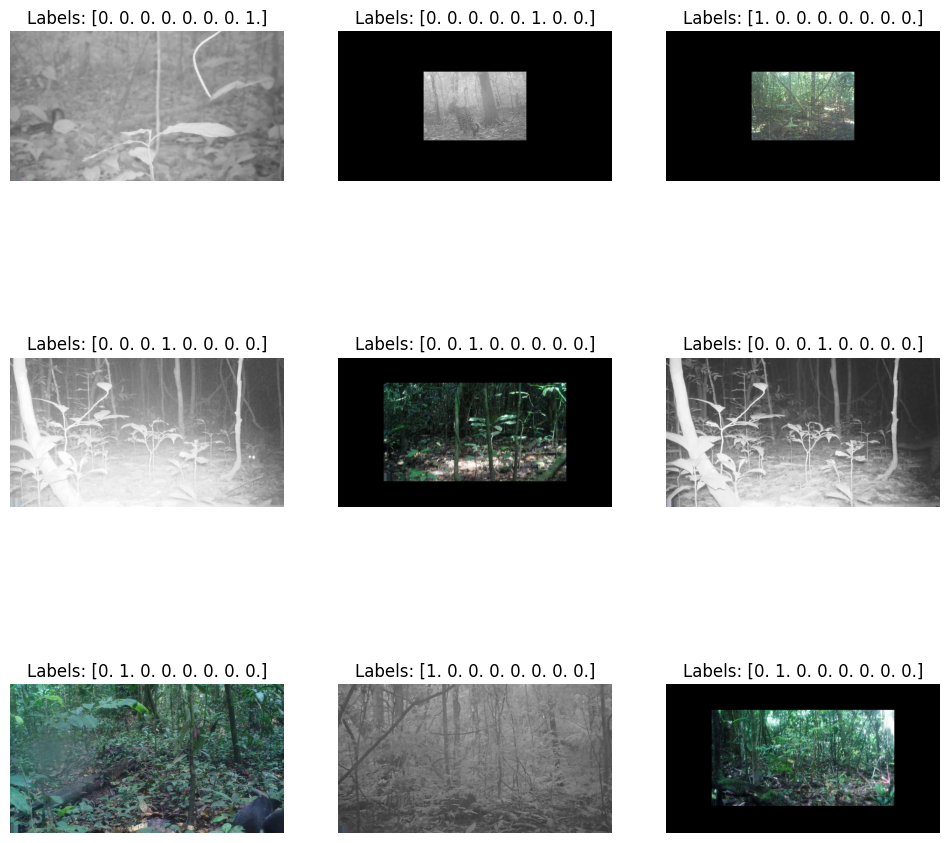

In [339]:
# Paths
dataset_folder = '../data/proc_train_features'  # Path to the folder with images
labels_file = '../data/train_labels_with_augm.csv'  # Path to the CSV file with labels
# Image parameters
img_width, img_height = max_sizes(dataset_folder)
#img_height = 128  # Set your image height
#img_width = 128   # Set your image width
batch_size = 32

# Load labels from CSV
df = pd.read_csv(labels_file)

frac = 1.0

df = df.sample(frac=frac, random_state=1)


# Add a full path to each image in the dataframe
df['id'] = df['id'].apply(lambda x: os.path.join(dataset_folder, x+'.jpg'))

# Perform stratified split based on the labels
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df[df.columns[1:]])

# Data generator
datagen = ImageDataGenerator(rescale=1./255)  # Rescale pixel values to [0, 1]
# Create the training generator
train_generator = datagen.flow_from_dataframe(
    dataframe=train_df,
    directory=None,
    x_col='id',
    y_col=train_df.columns[1:],  # All columns except 'ID' are labels
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='raw'
)
# Create the validation generator
val_generator = datagen.flow_from_dataframe(
    dataframe=val_df,
    directory=None,
    x_col='id',
    y_col=val_df.columns[1:],
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='raw'
)



# Example: Display a batch of images and labels
images, labels = next(train_generator)  # Get a batch of images and labels
plt.figure(figsize=(12, 12))
for i in range(9):  # Display first 9 images
    plt.subplot(3, 3, i + 1)
    plt.imshow(images[i])
    plt.title(f"Labels: {labels[i]}")
    plt.axis('off')
plt.show()

In [340]:
model = Sequential([
    Conv2D(16, (3, 3), activation='relu', input_shape=(img_height, img_width, 3)),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(16, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(16, activation='relu'),
    Dense(len(df.columns) - 1, activation='softmax')  # Output layer for multi-label classification
])
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
# Train the model
model.fit(train_generator, validation_data=val_generator, epochs=10)

Epoch 1/10


2024-08-29 18:53:50.898164: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


413/413 [==============================] - 195s 464ms/step - loss: 6.3254 - accuracy: 0.1977 - val_loss: 5.1301 - val_accuracy: 0.2482
Epoch 2/10
413/413 [==============================] - 206s 498ms/step - loss: 2.9619 - accuracy: 0.2780 - val_loss: 3.6923 - val_accuracy: 0.2454
Epoch 3/10
413/413 [==============================] - 231s 560ms/step - loss: 5.7699 - accuracy: 0.1991 - val_loss: 3.9687 - val_accuracy: 0.2009
Epoch 4/10
413/413 [==============================] - 226s 546ms/step - loss: 3.5002 - accuracy: 0.2175 - val_loss: 3.2132 - val_accuracy: 0.2372
Epoch 5/10
413/413 [==============================] - 228s 551ms/step - loss: 3.1150 - accuracy: 0.2249 - val_loss: 2.9632 - val_accuracy: 0.2299
Epoch 6/10
413/413 [==============================] - 231s 560ms/step - loss: 2.9180 - accuracy: 0.2393 - val_loss: 2.8799 - val_accuracy: 0.2482
Epoch 7/10
413/413 [==============================] - 237s 573ms/step - loss: 2.7604 - accuracy: 0.2537 - val_loss: 2.6859 - val_accura

In [ ]:
"""model.save('../models/firstCNNmodel')"""

In [258]:
# Load the saved model
with tf.device('/cpu:0'):
    new_model = tf.keras.models.load_model('../models/firstCNNmodel')

# Check its architecture
new_model.summary()

2024-08-29 12:37:19.612586: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2
2024-08-29 12:37:19.613029: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2024-08-29 12:37:19.613234: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2024-08-29 12:37:19.613315: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-08-29 12:37:19.613847: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 538, 958, 16)      448       
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 269, 479, 16)      0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 267, 477, 16)      2320      
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 133, 238, 16)      0         
 g2D)                                                            
                                                                 
 flatten_2 (Flatten)         (None, 506464)            0         
                                                                 
 dense_4 (Dense)             (None, 16)               

103/103 [==============================] - 14s 138ms/step


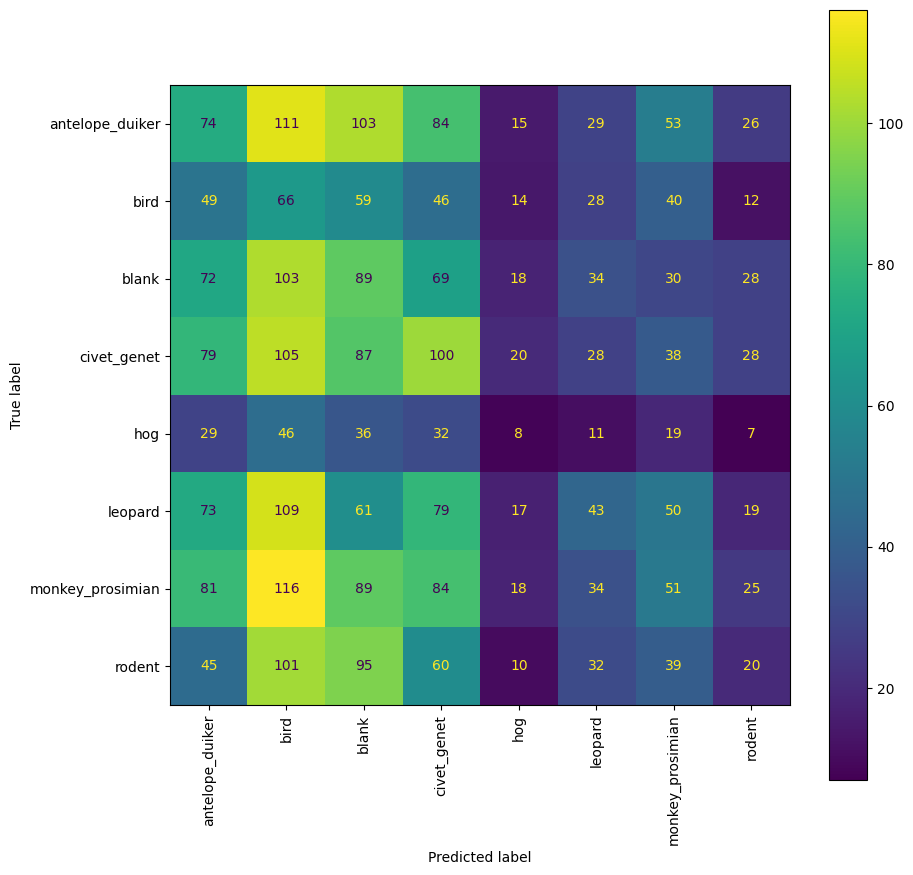

In [341]:
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Step 1: Get Predictions on Validation Data
val_preds = model.predict(val_generator)

# Convert predictions to binary format
# Identify index with highest value and set that entry to 1, all others to 0
val_preds_binary = np.zeros_like(val_preds)
val_preds_binary[np.arange(len(val_preds)), np.argmax(val_preds, axis=1)] = 1

# Step 2: Get True Labels
# Extract true labels from the validation generator
# Ensure true labels are in binary format, similar to val_preds_binary
val_true_labels = np.array(val_generator.labels)
# If labels are not binary, you might need to convert them
val_true_labels_binary = np.zeros_like(val_true_labels)
val_true_labels_binary[np.arange(len(val_true_labels)), np.argmax(val_true_labels, axis=1)] = 1

# Manually specify class labels
class_labels = ['antelope_duiker', 'bird', 'blank', 'civet_genet', 'hog', 'leopard', 'monkey_prosimian', 'rodent']  # Adjust as necessary

# Compute the confusion matrix
cm = confusion_matrix(np.argmax(val_true_labels_binary, axis=1), np.argmax(val_preds_binary, axis=1))

# Display the confusion matrix
fig, ax = plt.subplots(figsize=(10, 10))
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels).plot(ax=ax, xticks_rotation=90, colorbar=True)
plt.show()